# Reflecting Cosmic Ray analysis
This notebook analyzes pairs of tracks from simulated cosmic ray events, comparing upstream and downstream properties to extract the momentum resolution and shift due to material effects.
It uses root, uproot, and standard python numerical and plotting packages.

In [2]:
import os
import uproot 
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#import tensorflow as tf
from pathlib import Path
#from skspatial.objects import Vector
print("Hello world")

Hello world


This notebook processes TrkAna files constructed using the SelectReflections_module filter.
The TrkAna files contain 4 trees, one for each particle type reconstruction assumption: e+, e-, mu+, and mu-.
Each tree has the same structure, consisting of 2 tracks reconstructed from this particle: trk[0] is the upstream-going fit, trk[1] is the downstream-going fit.

In [12]:
input_dataset = np.empty
temp = np.empty
signal = np.empty
backgnd = np.empty

up_up_time = []
up_down_time = []
down_down_time = []
upmcpdg = []
downmcpdg = []
upmc_px = []
upmc_py = []
upmc_pz = []
up_px = []
up_py = []
up_pz = []
down_px = []
down_py = []
down_pz = []

up_posx = []
up_posy = []
down_posx = []
down_posy = []

nipa_up = []
nipa_down = []
nst_up = []
nst_down = []
for batch,rep in uproot.iterate(files,filter_name="/trk|trksegs|trkmcsim/i",report=True):
    print("Fields available in 'trksegs':", ak.fields(batch["trksegs"]))
    # upstream and downstream tracks
    upstream = batch["trksegs"][:,0]
    downstream = batch["trksegs"][:,1]
    print("uspstream ",len(upstream)," downstream ",len(downstream))
    uptrkmcsim = batch["trkmcsim"][:,0][:,0] # primary MC particle matched to the upstream track
    downtrkmcsim = batch["trkmcsim"][:,1][:,0] # primary MC particle matched to the downstream track
    # find the samples at the tracker entrance
    up_up = (upstream["sid"] == 0) & (upstream['mom']['fCoordinates']['fZ'] < 0) # exiting the tracker
    up_down = (upstream["sid"] == 0) & (upstream['mom']['fCoordinates']['fZ'] > 0) # re-entering the tracker
    down_down = (downstream["sid"] == 0) & (downstream['mom']['fCoordinates']['fZ'] > 0) # entering the tracker
    has_up_up = ak.sum(up_up,axis=1) > 0
    has_up_down = ak.sum(up_down,axis=1) > 0
    has_down_down = ak.sum(down_down,axis=1) > 0
    has_all = has_up_up & has_up_down & has_down_down
    up_up = up_up[has_all]
    up_down = up_down[has_all]
    down_down = down_down[has_all]
 #   print("has_all ",len(has_up_up),len(has_up_down),len(has_down_down),len(has_all))
#    #print("has_all ",ak.num(has_up_up,axis=1),ak.num(has_up_down,axis=1),ak.num(has_down_down,axis=1),ak.num(has_all,axis=1))
#    print("nums axis=0", ak.num(up_up, axis=0), ak.num(up_down, axis=0), ak.num(down_down, axis=0))
#    print("nums axis=1", ak.num(up_up, axis=1), ak.num(up_down, axis=1), ak.num(down_down, axis=1))
#    print("masked", ak.num(upstream[has_all], axis=0), ak.num(upstream[has_all], axis=1))
    up_up_time.extend(ak.flatten(upstream[has_all][up_up]['time']))                      
    up_down_time.extend(ak.flatten(upstream[has_all][up_down]['time']))
    down_down_time.extend(ak.flatten(downstream[has_all][down_down]['time']))
    uptrkmcsim = uptrkmcsim[has_all]
    downtrkmcsim = downtrkmcsim[has_all]
    upmcpdg.extend(uptrkmcsim['pdg'])
    downmcpdg.extend(downtrkmcsim['pdg'])
    
    up_px.extend(ak.flatten(upstream[has_all][up_down]['mom']['fCoordinates']['fX']))
    up_py.extend(ak.flatten(upstream[has_all][up_down]['mom']['fCoordinates']['fY']))
    up_pz.extend(ak.flatten(upstream[has_all][up_down]['mom']['fCoordinates']['fZ']))
    down_px.extend(ak.flatten(downstream[has_all][down_down]['mom']['fCoordinates']['fX']))
    down_py.extend(ak.flatten(downstream[has_all][down_down]['mom']['fCoordinates']['fY']))
    down_pz.extend(ak.flatten(downstream[has_all][down_down]['mom']['fCoordinates']['fZ']))

    up_posx.extend(ak.flatten(upstream[has_all][up_down]['pos']['fCoordinates']['fX']))
    up_posy.extend(ak.flatten(upstream[has_all][up_down]['pos']['fCoordinates']['fY']))
    down_posx.extend(ak.flatten(downstream[has_all][down_down]['pos']['fCoordinates']['fX']))
    down_posy.extend(ak.flatten(downstream[has_all][down_down]['pos']['fCoordinates']['fY']))
    
    nipaup = batch["trk.nipaup"][:,0] # only need upstream track for material intersection counting
    nipadown = batch["trk.nipadown"][:,0]
    nstup = batch["trk.nstup"][:,0]
    nstdown = batch["trk.nstdown"][:,0]
    nipaup = nipaup[has_all]
    nipadown = nipadown[has_all]
    nstup = nstup[has_all]
    nstdown = nstdown[has_all]
    
    nipa_up.extend(nipaup)
    nipa_down.extend(nipadown)
    nst_up.extend(nstup)    
    nst_down.extend(nstdown)
    

deltapdg = np.subtract(upmcpdg,downmcpdg)
decay = []
for dpdg in deltapdg :
    decay.append(dpdg != 0)
decay = np.array(decay)

up_mom2 = np.square(up_px) + np.square(up_py) + np.square(up_pz)
up_mom = np.sqrt(up_mom2)
down_mom2 = np.square(down_px) + np.square(down_py) + np.square(down_pz)
down_mom = np.sqrt(down_mom2)

up_posx = np.array(up_posx)
up_posy = np.array(up_posy)
down_posx = np.array(down_posx)
down_posy = np.array(down_posy)

nipa = np.add(nipa_up,nipa_down)
nst = np.add(nst_up,nst_down)
nmat = np.add(nipa,nst)

print("Upstream momentum ",len(up_mom),up_mom[:10])
print("Downstream momentum ",len(down_mom),down_mom[:10])
print("Upstream fit upstream time ",len(up_up_time),up_up_time[:10])
print("Upstream fit downstream time",len(up_down_time),up_down_time[:10])
print("Downstream fit downstream time",len(down_down_time),down_down_time[:10])
print("Upstream MC PDG code",len(upmcpdg),upmcpdg[:10])
print("Downstream MC PDG code",len(downmcpdg),downmcpdg[:10])
print("Decays ",decay.sum())
print("nmat ",len(nmat))
print("N ST ",nst[:10]," N IPA ",nipa[:10], "N mat ", nmat[:10])


Fields available in 'trksegs': ['mom', 'pos', 'time', 'dmom', 'momerr', 'inbounds', 'gap', 'early', 'late', 'sid', 'sindex']
uspstream  17  downstream  17
Upstream momentum  17 [ 88.72054   77.18203   76.41518   86.462776  73.6482    82.89029
 100.26179   45.102142 114.58458   73.75964 ]
Downstream momentum  17 [ 88.85178   77.444336  74.61972   86.156876  67.835365  82.86123
  99.37011   44.344646 114.77665   73.50832 ]
Upstream fit upstream time  17 [791.2595864891081, 631.1596816295064, 1157.0246589749927, 863.8595146052817, 978.5759806240161, 481.6281126014945, 960.2596921576901, 640.1661608476118, 700.9679987817314, 1498.9331243208494]
Upstream fit downstream time 17 [848.0066844004847, 682.1531754384955, 1226.6696936533208, 921.3555891737991, 1029.7148536170612, 542.8695526806285, 1008.0161445570184, 691.7564735301007, 752.3882266943174, 1561.7015045517044]
Downstream fit downstream time 17 [845.557292661109, 681.8897517678457, 1228.244761236923, 921.1102214601866, 1036.535439923

Label tracks by the MC truth of the particle

In [13]:
true_em = []
true_mum = []
for mcpdg in upmcpdg :
    true_em.append(mcpdg == 11)
    true_mum.append(mcpdg == 13)
true_em = np.array(true_em)
true_mum = np.array(true_mum)
if particle == "electron":
    true_particle = true_em
else:
    true_particle = true_mum
print("True Electrons",len(true_em),true_em[:10])
print("True Muons",len(true_mum),true_mum[:10])
print("True Particles",len(true_mum),true_particle[:10])

True Electrons 17 [ True  True  True  True False  True  True  True  True  True]
True Muons 17 [False False False False False False False False False False]


N true electrons  16  N true muons  0


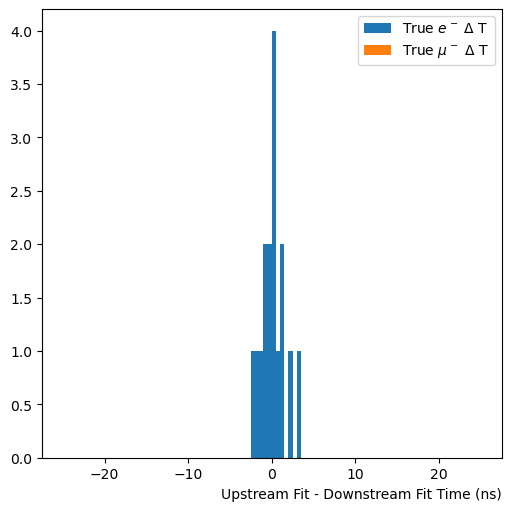

In [14]:
time_diff = np.subtract(up_down_time,down_down_time)
em_time_diff = time_diff[true_em]
mum_time_diff = time_diff[true_mum]
print("N true electrons ",len(em_time_diff), " N true muons ", len(mum_time_diff))
fig, ax = plt.subplots(layout='constrained', figsize=(5, 5))
ehist = ax.hist(em_time_diff,label="True $e^-$ $\Delta$ T", bins=100,range=(-25,25))
muhist = ax.hist(mum_time_diff,label="True $\mu^-$ $\Delta$ T", bins=100,range=(-25,25))
ax.set_xlabel('Upstream Fit - Downstream Fit Time (ns)',loc='right')
ax.legend()

In [15]:
abs_time_diff = np.absolute(time_diff)
good_tdiff = []
max_tdiff = 5.0
for tdiff in abs_time_diff :
    good_tdiff.append( tdiff <  max_tdiff)
good_tdiff = np.array(good_tdiff)
print("Good Delta T ",len(good_tdiff),good_tdiff[:10])
true_good_tdiff = good_tdiff[true_particle]
eff = good_tdiff.sum()/true_particle.sum()
pur = true_good_tdiff.sum()/good_tdiff.sum()
print("For Delta T < ", max_tdiff , " efficiency = ",eff," purity = ",pur)

Good electron  17 [True, True, True, True, False, True, True, True, True, True]
For Delta T <  5.0  efficiency =  1.0  purity =  1.0


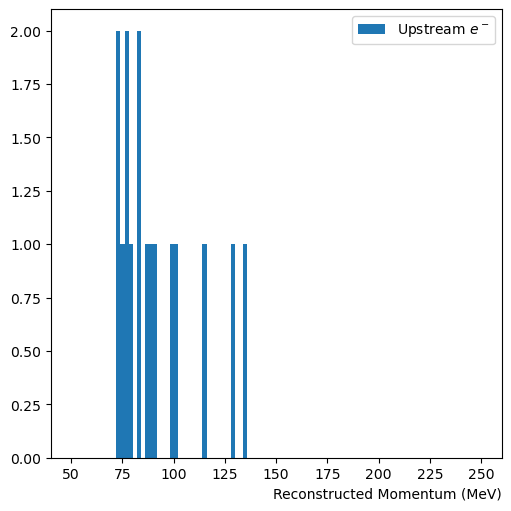

In [16]:
fig, ax = plt.subplots(layout='constrained', figsize=(5, 5))
uphist = ax.hist(up_mom,label="Upstream " + plabel, bins=100,range=(50,250))
ax.set_xlabel('Reconstructed Momentum (MeV)',loc='right')
ax.legend()

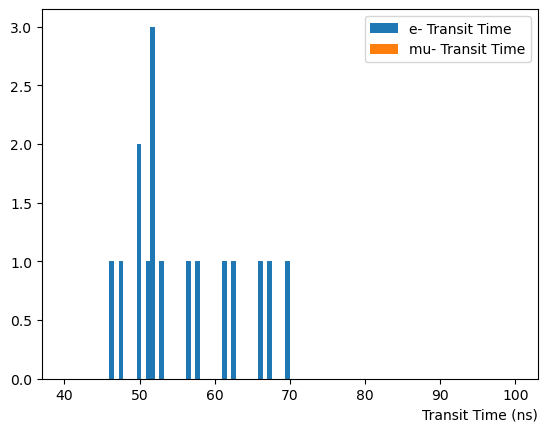

In [17]:
transit_time = np.subtract(up_down_time,up_up_time)
em_transit_time = transit_time[true_em]
mum_transit_time = transit_time[true_mum]
plt.hist(em_transit_time,label="e- Transit Time", bins=100,range=(40,100))
plt.hist(mum_transit_time,label="mu- Transit Time", bins=100,range=(40,100))
plt.xlabel('Transit Time (ns)', loc='right')
plt.legend()

nomat  17


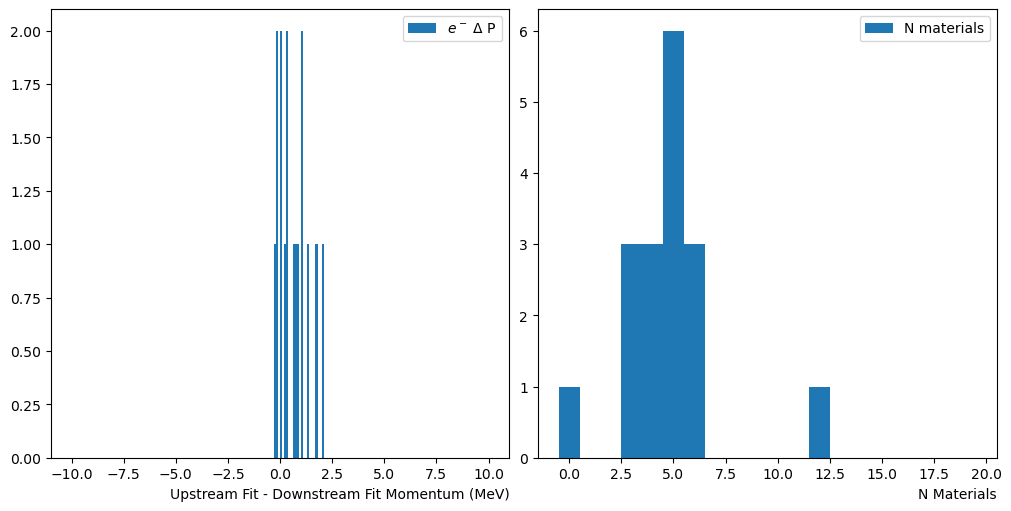

In [18]:
mom_diff = np.subtract(up_mom,down_mom)
nomat = []
for nm in nmat :
    nomat.append( nm <4 )
print("nomat ",len(nomat))
good_tdiff_nomat = np.logical_and(nomat,good_tdiff)

em_mom_diff = mom_diff[good_tdiff]
em_mom_diff_nomat = mom_diff[good_tdiff_nomat]
nmat_good = nmat[good_tdiff]
up_mom_good = up_mom[good_tdiff]

fig, (ax0, ax1 )  = plt.subplots(1,2,layout='constrained', figsize=(10,5))
ax0.hist(em_mom_diff,label=plabel + "$\Delta$ P",bins=200,range=(-10,10))
ax0.set_xlabel("Upstream Fit - Downstream Fit Momentum (MeV)",loc='right')
ax0.legend()
ax1.hist(nmat,label="N materials",bins=20,range=(-0.5,19.5))
ax1.set_xlabel("N Materials",loc='right')
ax1.legend()


In [1]:
up_rho2 = np.square(up_posx) + np.square(up_posy)
up_rho = np.sqrt(up_rho2);
down_rho2 = np.square(down_posx) + np.square(down_posy)
down_rho = np.sqrt(down_rho2)
drho = up_rho - down_rho

up_phi = np.arctan2(up_posy, up_posx)
down_phi = np.arctan2(down_posy, down_posx)
dphi = up_phi - down_phi

# \rho isn't working
fig, (ax0, ax1 )  = plt.subplots(1,2,layout='constrained', figsize=(10,5))
drho = ax0.hist(drho,label=plabel + "$\Delta$ \u03C1", bins=100,range=(-500,500))
ax0.set_xlabel("Upstream - Downstream \u03C1 (mm)",loc='right')
ax0.legend()
dphi = ax1.hist(dphi,label=plabel+ " $\Delta$ $\phi$",bins=100,range=(-3.14,3.14))
ax1.set_xlabel("Upstream - Downstream $\phi$",loc='right')
ax1.legend()

NameError: name 'np' is not defined